## DSAI midterm

### part 2
### 特徵選取

根據 part 1 特徵選取 重要度高於 200 的特徵來跑模型

submission scored : 0.91642


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

from itertools import product
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from xgboost import plot_importance

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
import pickle
import gc
import sys
sys.version_info


sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)

## read data

In [2]:
data = pd.read_pickle('Predict Future Sales/data.pkl')
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
#    'city_code',
    'item_category_id',
#    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
#    'item_cnt_month_lag_6',
#    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
#    'date_item_avg_item_cnt_lag_3',
#    'date_item_avg_item_cnt_lag_6',
#    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
#    'date_shop_avg_item_cnt_lag_2',
#    'date_shop_avg_item_cnt_lag_3',
#    'date_shop_avg_item_cnt_lag_6',
#    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
#    'date_city_avg_item_cnt_lag_1',
#    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
#    'days',
#    'item_shop_last_sale',
    'item_last_sale',
#    'item_shop_first_sale',
    'item_first_sale',
]]

### train, test, validation split

In [4]:
# take train, validation, test
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']

X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']

X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)



In [5]:
del data
gc.collect();

## build model

In [6]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
    nthread = 8,
    seed=10)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts



C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.15701	validation_1-rmse:1.12426
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10954	validation_1-rmse:1.08638
[2]	validation_0-rmse:1.06845	validation_1-rmse:1.05491
[3]	validation_0-rmse:1.0335	validation_1-rmse:1.02839
[4]	validation_0-rmse:1.00705	validation_1-rmse:1.01044
[5]	validation_0-rmse:0.981225	validation_1-rmse:0.991323
[6]	validation_0-rmse:0.959761	validation_1-rmse:0.976103
[7]	validation_0-rmse:0.941784	validation_1-rmse:0.963873
[8]	validation_0-rmse:0.926195	validation_1-rmse:0.953527
[9]	validation_0-rmse:0.912968	validation_1-rmse:0.945126
[10]	validation_0-rmse:0.903101	validation_1-rmse:0.939665
[11]	validation_0-rmse:0.893462	validation_1-rmse:0.934573
[12]	validation_0-rmse:0.886358	validation_1-rmse:0.931052
[13]	validation_0-rmse:0.878999	validation_1-rmse:0.927023
[14]	validation_0-rmse:0.872493	vali

473.2912609577179

## save predidtion

In [7]:
test  = pd.read_csv('Predict Future Sales/test.csv').set_index('ID')

Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_st.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))



## plot importance feature

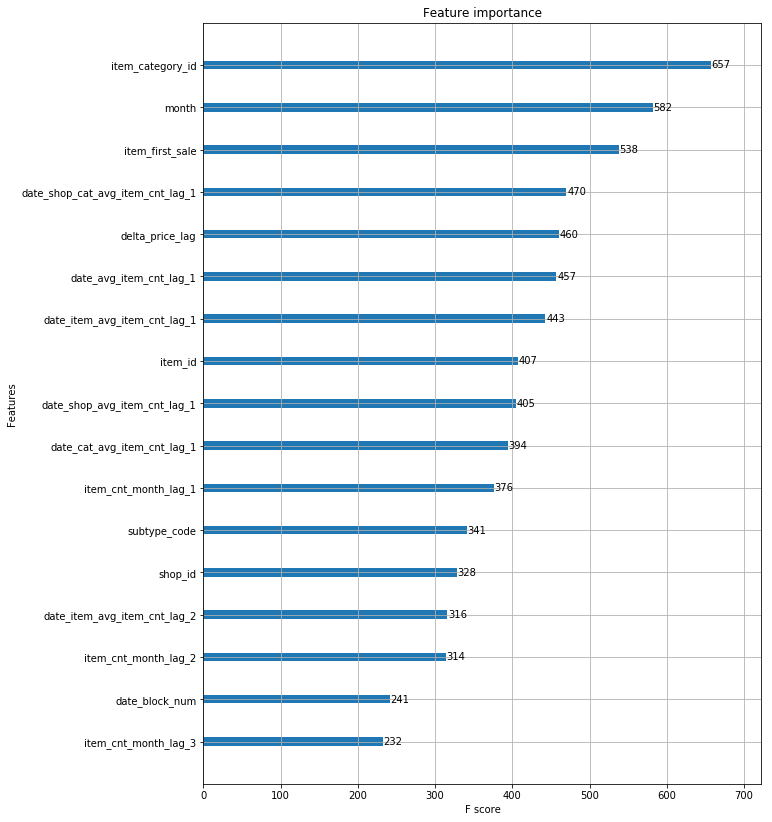

In [8]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

